In [1]:
%cd ..

/home/feodor/Jupyter/depth-poset


/home/feodor/Jupyter/jupyter-env/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import numpy as np
import pandas as pd
import gudhi as gh
import networkx as nx

from matplotlib import pyplot as plt

from src.depth import DepthPoset
from src.drow import plot_filtred_complex2d, plot_simplex, enumerate_points

# Define SImplicial Trees and Depth Posets

In [3]:
def get_random_reordered_stree(stree, change=1.):
    order = np.array([simplex for simplex, value in stree.get_filtration()], dtype=object)
    dims = np.array([len(s) for s in order])
    new_order = []
    for dim in np.unique(dims):
        order_dim = order[dims == dim]
        old_index_change = np.random.choice(np.arange(len(order_dim)), int(change*len(order_dim)), replace=False)
        new_index_change = np.random.choice(old_index_change, len(old_index_change), replace=False)
        order_dim[old_index_change] = order_dim[new_index_change]
        new_order.extend(order_dim)
        
    new_stree = gh.SimplexTree()
    for value, simplex in enumerate(new_order):
        new_stree.insert(simplex, value)
    return new_stree

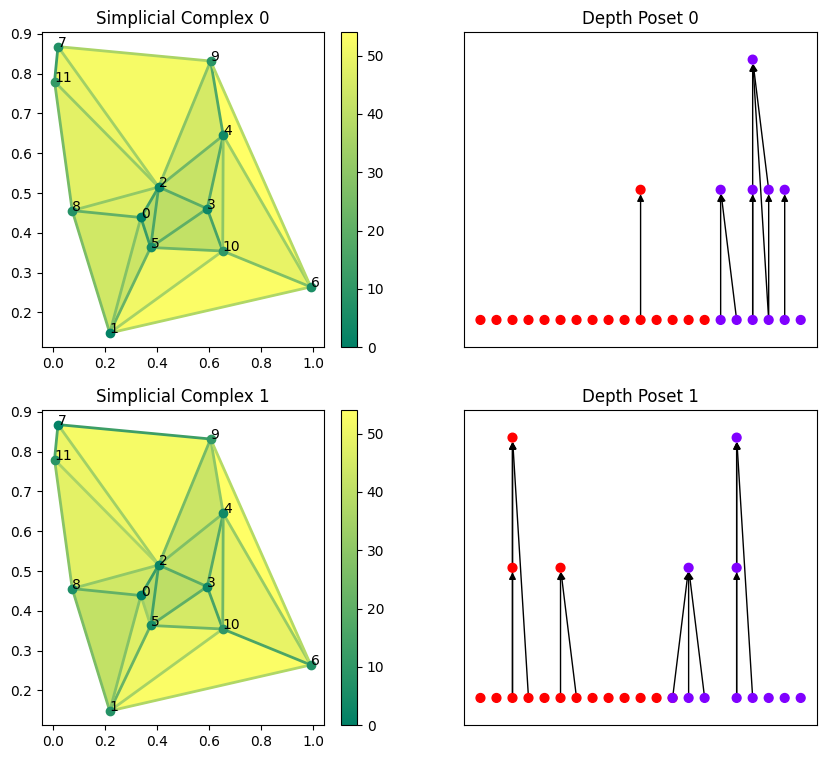

In [13]:
n = 12
dim = 2
points = np.random.random([n, dim])

stree = gh.AlphaComplex(points).create_simplex_tree()
order = []
for d in range(dim + 1):
    for simplex, value in stree.get_filtration():
        if len(simplex) == d + 1:
            order.append(simplex)
stree0 = gh.SimplexTree()
for value, simplex in enumerate(order):
    stree0.insert(simplex, value)

dp0 = DepthPoset.from_simplex_tree(stree0)


stree1 = get_random_reordered_stree(stree0, change=0.5)
dp1 = DepthPoset.from_simplex_tree(stree1)

fig, axs = plt.subplots(2, 2, figsize=(10, 9))

for i, (stree, dp) in enumerate(zip([stree0, stree1], [dp0, dp1])):
    axs[i, 0].set_title(f'Simplicial Complex {i}')
    sm = plot_filtred_complex2d(stree, points, cmap='summer', ax=axs[i, 0])
    plt.colorbar(sm, ax=axs[i, 0])
    enumerate_points(points, ax=axs[i, 0])
    
    axs[i, 1].set_title(f'Depth Poset {i}')
    cmap = plt.get_cmap('rainbow')
    node_colors = [cmap(node.dim/(dim - 1)) for node in dp0.nodes]
    nx.draw_networkx(dp.get_transitive_closure(), dp.hasse_layout(), 
                     node_color=node_colors, node_size=40, with_labels=False,
                     ax=axs[i, 1])

plt.show()

In [14]:
df_filtrations = pd.DataFrame({'Complex 0': {str(key): value for key, value in stree0.get_filtration()}, 
                               'Complex 1': {str(key): value for key, value in stree1.get_filtration()}})
#df_filtrations[df_filtrations['Complex 0'] != df_filtrations['Complex 1']]
pd.Series({ord: np.linalg.norm(df_filtrations['Complex 1'] - df_filtrations['Complex 0'], ord=ord) for ord in [0, np.inf]})

0.0    24.0
inf    23.0
dtype: float64

# Depth Poset Deifference Scores

In [15]:
def jacard_index(a, b):
    """
    Calculate the Jaccard index
    """
    intersection = set(a) & set(b)
    union = set(a) | set(b)
    if len(union) == 0:
        return 1.0
    return len(intersection) / len(union)

In [16]:
def jacard_cells(dp0, dp1):
    """
    The Jacard Index of cells sets represented in 2 Depth Posets.
    """
    cells0 = [node.source[0] for node in dp0.nodes] + [node.source[1] for node in dp0.nodes]
    cells1 = [node.source[0] for node in dp1.nodes] + [node.source[1] for node in dp1.nodes]
    return jacard_index(cells0, cells1)

In [17]:
jacard_cells(dp0, dp1)

1.0

In [18]:
def jacard_nodes_cells(dp0, dp1):
    """
    The Jacard Index of nodes sources sets of 2 Depth Posets.
    """
    return jacard_index([node.source for node in dp0.nodes], [node.source for node in dp1.nodes])

In [19]:
jacard_nodes_cells(dp0, dp1)

0.5428571428571428

In [20]:
def jacard_edges_cells(dp0, dp1):
    """
    The Jacard Index of nodes sources sets of 2 Depth Posets.
    """
    return jacard_index([(node0.source, node1.source) for node0, node1 in dp0.edges], 
                        [(node0.source, node1.source) for node0, node1 in dp1.edges])
    

In [21]:
jacard_edges_cells(dp0, dp1)

0.11764705882352941